In [20]:
import sys
sys.path.append("./../")

import os

import numpy as np
import torch
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from torch.utils.data import DataLoader

from transformers import BertTokenizer, BertModel

from modules.tavqvae_generator.model import Generator
from modules.tavqvae_discriminator.tagan_model import Discriminator

from datasets.cub import CubDataset
from datasets.common import Collater
from config import Config

In [21]:
def show(img, figsize=(8, 4)):
    plt.figure(figsize=figsize)
    npimg = img.numpy()
    fig = plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    plt.show()

In [22]:
CONFIG = Config(local=True, model_path="models/tavqvae_e256x8138/")
CONFIG.load_config()

CONFIG.BATCH_SIZE = 2

train_dataset = CubDataset(root_img_path=CONFIG.root_img_path,
                           root_text_path=CONFIG.root_text_path,
                           imgs_list_file_path=CONFIG.imgs_list_file_path,
                           img_size=CONFIG.img_size)

In [23]:
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')

In [24]:
collater = Collater(tokenizer=bert_tokenizer)

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=CONFIG.BATCH_SIZE,
                          shuffle=True,
                          collate_fn=collater.collate_fn)

In [25]:
G = Generator(num_embeddings=CONFIG.vqvae_num_embeddings,
              img_embedding_dim=CONFIG.vqvae_embedding_dim,
              text_embedding_dim=bert_model.config.hidden_size,
              commitment_cost=CONFIG.vqvae_commitment_cost,
              decay=CONFIG.vqvae_decay,
              num_x2downsamples=CONFIG.vqvae_num_x2downsamples,
              num_resid_downsample_layers=CONFIG.vqvae_num_downsample_residual_layers,
              num_resid_bottleneck_layers=CONFIG.vqvae_num_bottleneck_residual_layers,
              text_rebuild_num_residual_layers=CONFIG.text_rebuild_num_residual_layers,
              use_batch_norm=True,
              vqvae_use_conv1x1=True)

G.load_model(root_path=CONFIG.save_model_path, model_name="TAVQVAE")

In [26]:
D = Discriminator(text_embedding_dim=bert_model.config.hidden_size)

D.load_state_dict(torch.load(os.path.join(CONFIG.save_model_path, "TAVQVAE_discriminator.pth"),
                             map_location=torch.device("cpu")))

<All keys matched successfully>

In [27]:
imgs, text_info = next(iter(train_loader))
token_tensor, token_type_tensor, mask_tensor, texts = text_info

with torch.no_grad():
    # See the models docstrings for the detail of the inputs
    outputs = bert_model(token_tensor,
                         attention_mask=mask_tensor,
                         token_type_ids=token_type_tensor)
    texth = outputs[0]
    # batch x seq_len x emb_dim --> to seq_len x batch x emb_dim
    texth = texth.transpose(1, 0)

    _, _, imgs_recon, _ = G.vqvae(imgs)

texth_neg = torch.cat((texth[:, -1, :].unsqueeze(1), texth[:, :-1, :]), 1)
mask_tensor_neg = torch.cat((mask_tensor[-1, :].unsqueeze(0), mask_tensor[:-1, :]), 0)

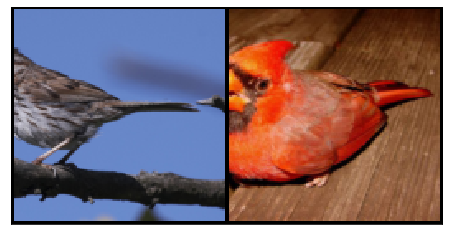

In [9]:
show(make_grid(imgs.data, nrow=2))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


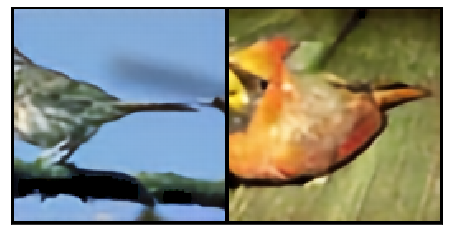

In [10]:
show(make_grid(imgs_recon.data, nrow=2))

In [11]:
real_logit, real_c_prob, real_c_prob_n = D(
    img=imgs_recon, txt=texth, len_txt=mask_tensor.sum(dim=1), negative=True)

In [12]:
torch.sigmoid(real_logit)

tensor([0.6639, 0.6663], grad_fn=<SigmoidBackward>)

In [13]:
real_c_prob

tensor([0.7391, 0.7573], grad_fn=<ProdBackward1>)

In [14]:
real_c_prob_n

tensor([0.7317, 0.7530], grad_fn=<ProdBackward1>)

In [15]:
fake, mask_recon, quantized, encoding_info, perplexity = G(
    imgh=imgs, texth=texth_neg, text_mask=mask_tensor_neg)

fake_logit, fake_c_prob = D(img=fake.detach(), txt=texth_neg, len_txt=mask_tensor_neg.sum(dim=1))

In [16]:
np.unique(mask_recon.data.numpy())

array([0.], dtype=float32)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


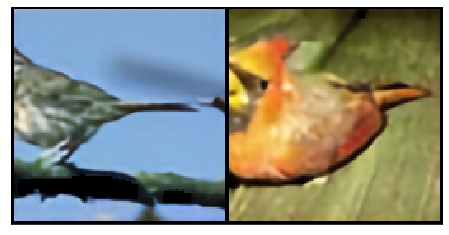

In [17]:
show(make_grid(fake.data, nrow=2))

In [18]:
torch.sigmoid(fake_logit)

tensor([0.6639, 0.6663], grad_fn=<SigmoidBackward>)

In [19]:
fake_c_prob

tensor([0.7317, 0.7530], grad_fn=<ProdBackward1>)